# Sub Labeling Data

Instead of getting average average the numbers, then getting their subfeatures, let's just get the subfeature for each number.

## Imports

In [1]:
import random

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels, horizontal_kernel, vertical_kernel, \
    load_intermediate_labels, generate_intermediate_curve_labels, save_intermediate_labels

## Set Device to GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [3]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

## Generating Additional Sub Labels

In [4]:
ex_7 = train_images[0]

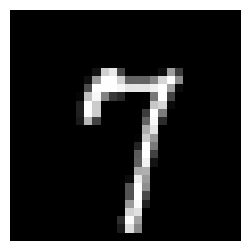

In [5]:
visualize_image(ex_7, "")

In [6]:
def visualize_chunks_in_position(image, chunk_size, min_intensity_threshold=0.1):
    """
    Extract chunks and visualize each against a black background in its original position.
    Only includes chunks with sufficient brightness.
    
    Parameters:
    - image: 2D numpy array (28x28 for MNIST)
    - chunk_size: size of each chunk
    - min_intensity_threshold: minimum average intensity (0-1) to keep a chunk
    """
    h, w = image.shape
    n_chunks_h = h // chunk_size
    n_chunks_w = w // chunk_size
    
    # Calculate number of chunks to show (potentially fewer after filtering)
    # We'll create a grid layout with a bit of extra space
    fig, axes = plt.subplots(n_chunks_h, n_chunks_w, figsize=(10, 10))
    
    # Handle the case of a single row or column
    if n_chunks_h == 1:
        axes = np.array([axes])
    if n_chunks_w == 1:
        axes = np.array([[ax] for ax in axes])

    chunks = []
    # Process each chunk position
    for i in range(n_chunks_h):
        for j in range(n_chunks_w):
            start_h = i * chunk_size
            start_w = j * chunk_size
            
            # Extract the chunk
            chunk = image[start_h:start_h+chunk_size, start_w:start_w+chunk_size]
            
            # Calculate average intensity (assuming values are 0-255)
            avg_intensity = np.mean(chunk) / 255.0
            
            # Create a blank image
            chunk_in_position = np.zeros_like(image)
            
            # Only place the chunk if it has enough brightness
            if avg_intensity > min_intensity_threshold:
                # Place the chunk in its original position
                chunk_in_position[start_h:start_h+chunk_size, start_w:start_w+chunk_size] = chunk
                axes[i, j].set_title(f"Avg: {avg_intensity:.2f}")
                chunks.append(chunk_in_position)
            
                # Display the chunk in its original position against a black background
                axes[i, j].imshow(chunk_in_position, cmap='gray')
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

    return chunks

### Notes

Some issues with chunking to get import sub features and then build up:
- unequal amount of important subfeatures between numbers
- how do we handle this for each layer?
  - do we need to just have each of the 16 regions above to correspond to a "feature"? then condense it to 4 for the next layer?
 
**Idea:** find the n unique subfeatures of digits. Then group these into n/k unique subfeatures, and so on, until we hit our classifier. Each node/(set of) filter(s) should correspond to a unique subfeature. As we go across layers, these subfeatures build upon each other to construct our digit.

To find the n unique subfeatures, we use our chunking technique above. After finding chunks for each digit, we also use similarity search s.t. we can combine important features across digits (i.e. subfeatures that form loops in a 0 may also coincide with the subfeatures to form a loop in an 8). 

The tricky part here is space... do we take that into account when creating these subfeatures? e.g. horizontal line subfeatures might be different at different parts of a digit 

In [7]:
def get_subfeatures(image, chunk_size, min_intensity_threshold=0.1):
    """
    """
    h, w = image.shape
    n_chunks_h = h // chunk_size
    n_chunks_w = w // chunk_size

    chunks = []
    # Process each chunk position
    for i in range(n_chunks_h):
        for j in range(n_chunks_w):
            start_h = i * chunk_size
            start_w = j * chunk_size
            
            # Extract the chunk
            chunk = image[start_h:start_h+chunk_size, start_w:start_w+chunk_size]
            
            # Calculate average intensity (assuming values are 0-255)
            avg_intensity = np.mean(chunk) / 255.0
            
            # Create a blank image
            chunk_in_position = np.zeros_like(image)
            
            # Only place the chunk if it has enough brightness
            if avg_intensity > min_intensity_threshold:
                # Place the chunk in its original position
                chunk_in_position[start_h:start_h+chunk_size, start_w:start_w+chunk_size] = chunk
                chunks.append(chunk_in_position)

    return chunks

**New approach:** it's too difficult to extract subfeatures comparing across every single image in the dataset. So, instead, we'll get the average digit, then get it's important subfeatures, and then get the unique subfeatures across the subfeatures of each average digit.

In [16]:
min_sub_features = []
sub_features = []
for img in train_images:
    chunks = get_subfeatures(image=img, chunk_size=14, min_intensity_threshold=-10)
    if chunks:
        min_sub_features.extend(chunks)

        sub_f = [chunks[0] + chunks[1], chunks[2] + chunks[3]]
        sub_features.extend(sub_f)

In [17]:
len(min_sub_features), len(sub_features), len(train_images)

(200000, 100000, 50000)

In [18]:
save_intermediate_labels("min_sub_feature_dict_v2.pkl", min_sub_features)
save_intermediate_labels("sub_feature_dict_v2.pkl", sub_features)

Intermediate label has been saved!
Intermediate label has been saved!
